# Furniture Classification - Data Processing

This notebook handles the complete data processing pipeline for furniture classification using CNN.

## Dataset Overview
- **Categories**: 5 (Almirah, Chair, Fridge, Table, TV)
- **Images per category**: 3,000
- **Total images**: 15,000
- **Format**: JPEG images

## Objectives
1. Environment setup and library installation
2. Data exploration and visualization
3. Data preprocessing and normalization
4. Data augmentation for improved generalization
5. Train/validation/test split
6. Data preparation for CNN model training

In [2]:
# Environment Detection and Setup
import sys
import os

IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install kagglehub tensorflow keras numpy pandas matplotlib seaborn scikit-learn pillow opencv-python
    
    import kagglehub
    path = kagglehub.dataset_download("udaysankarmukherjee/furniture-image-dataset")
    print("Dataset downloaded successfully for Google Colab!")
else:
    path = "../Furnitures"
    print("Running on local machine")
    
    if os.path.exists(path):
        print("Local dataset found!")
    else:
        print("Local dataset not found. Please ensure the 'Furnitures' folder is in the parent directory.")

print(f"Environment: {'Google Colab' if IN_COLAB else 'Local Machine'}")

Running on local machine
Local dataset found!
Environment: Local Machine


In [3]:
# Import libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from collections import Counter
import random

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Set seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

plt.rcParams['figure.dpi'] = 100
if IN_COLAB:
    %matplotlib inline
else:
    import matplotlib
    matplotlib.use('Agg')
    %matplotlib inline

print("Libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")
print("Ready for data processing!")

2025-08-01 21:59:33.751452: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-01 21:59:33.756268: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-01 21:59:33.770272: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754078373.798075    6311 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754078373.805362    6311 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1754078373.821652    6311 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

Libraries imported successfully!
TensorFlow version: 2.19.0
Ready for data processing!


## 2. Data Exploration and Analysis

In [4]:
# Define dataset path and categories
DATA_PATH = path
CATEGORIES = ['almirah_dataset', 'chair_dataset', 'fridge dataset', 'table dataset', 'tv dataset']
CLASS_NAMES = ['almirah', 'chair', 'fridge', 'table', 'tv']

folder_to_class = dict(zip(CATEGORIES, CLASS_NAMES))

print("Dataset Path:", DATA_PATH)
print("Categories:", CATEGORIES)
print("Class Names:", CLASS_NAMES)

if os.path.exists(DATA_PATH):
    print("\nDataset path exists!")
    contents = os.listdir(DATA_PATH)
    print("Contents:", contents)
    
    missing_folders = []
    for category in CATEGORIES:
        category_path = os.path.join(DATA_PATH, category)
        if not os.path.exists(category_path):
            missing_folders.append(category)
    
    if missing_folders:
        print(f"Missing folders: {missing_folders}")
    else:
        print("All expected category folders found!")
else:
    print(f"Dataset path does not exist: {DATA_PATH}")

Dataset Path: ../Furnitures
Categories: ['almirah_dataset', 'chair_dataset', 'fridge dataset', 'table dataset', 'tv dataset']
Class Names: ['almirah', 'chair', 'fridge', 'table', 'tv']

Dataset path exists!
Contents: ['fridge dataset', 'almirah_dataset', 'tv dataset', 'table dataset', 'chair_dataset']
All expected category folders found!


In [5]:
# Explore dataset structure and count images
def explore_dataset(data_path, categories):
    dataset_info = {}
    total_images = 0
    
    for category in categories:
        category_path = os.path.join(data_path, category)
        if os.path.exists(category_path):
            image_files = [f for f in os.listdir(category_path) 
                          if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
            count = len(image_files)
            dataset_info[category] = count
            total_images += count
            print(f"{category}: {count} images")
        else:
            print(f"Warning: {category_path} does not exist!")
            dataset_info[category] = 0
    
    print(f"\nTotal images: {total_images}")
    return dataset_info

dataset_info = explore_dataset(DATA_PATH, CATEGORIES)

almirah_dataset: 3000 images
chair_dataset: 3000 images
fridge dataset: 3000 images
table dataset: 3000 images
tv dataset: 3000 images

Total images: 15000


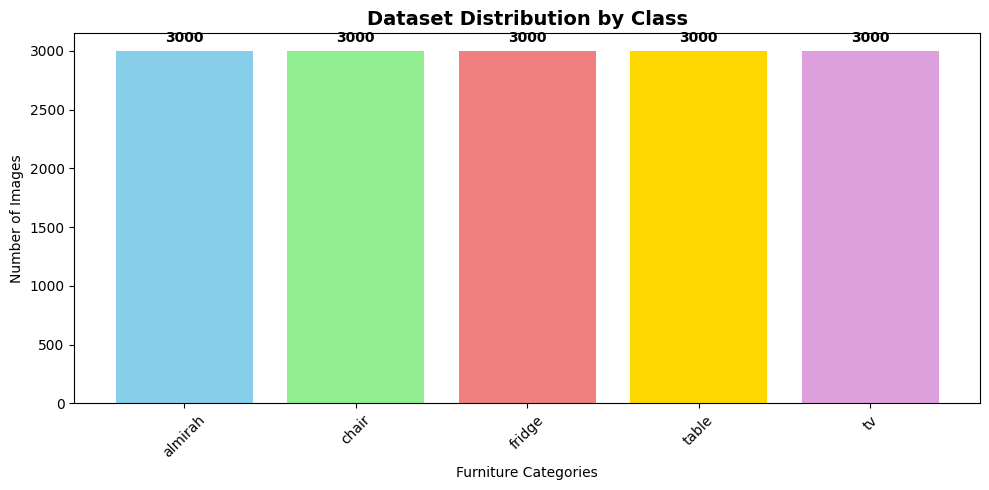

Dataset is balanced with 3000 images per class
Total images: 15000


In [6]:
# Visualize dataset distribution
plt.figure(figsize=(10, 5))

class_names_short = [folder_to_class[cat] for cat in CATEGORIES]
counts = [dataset_info[cat] for cat in CATEGORIES]

plt.bar(class_names_short, counts, color=['skyblue', 'lightgreen', 'lightcoral', 'gold', 'plum'])
plt.title('Dataset Distribution by Class', fontsize=14, fontweight='bold')
plt.xlabel('Furniture Categories')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)

for i, count in enumerate(counts):
    plt.text(i, count + 50, str(count), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print(f"Dataset is balanced with {counts[0]} images per class")
print(f"Total images: {sum(counts)}")

## 3. Image Analysis and Visualization

In [7]:
# Analyze sample images
def analyze_sample_images(data_path, categories, sample_size=50):
    widths, heights = [], []
    
    for category in categories:
        category_path = os.path.join(data_path, category)
        if os.path.exists(category_path):
            image_files = [f for f in os.listdir(category_path) 
                          if f.lower().endswith(('.jpg', '.jpeg', '.png'))][:sample_size]
            
            for img_file in image_files:
                img_path = os.path.join(category_path, img_file)
                try:
                    with Image.open(img_path) as img:
                        width, height = img.size
                        widths.append(width)
                        heights.append(height)
                except Exception as e:
                    print(f"Error processing {img_path}: {e}")
    
    print(f"Sample size: {len(widths)} images")
    print(f"Width range: {min(widths)} - {max(widths)} pixels (avg: {np.mean(widths):.0f})")
    print(f"Height range: {min(heights)} - {max(heights)} pixels (avg: {np.mean(heights):.0f})")
    
    return widths, heights

widths, heights = analyze_sample_images(DATA_PATH, CATEGORIES)

Sample size: 250 images
Width range: 115 - 348 pixels (avg: 203)
Height range: 169 - 220 pixels (avg: 193)


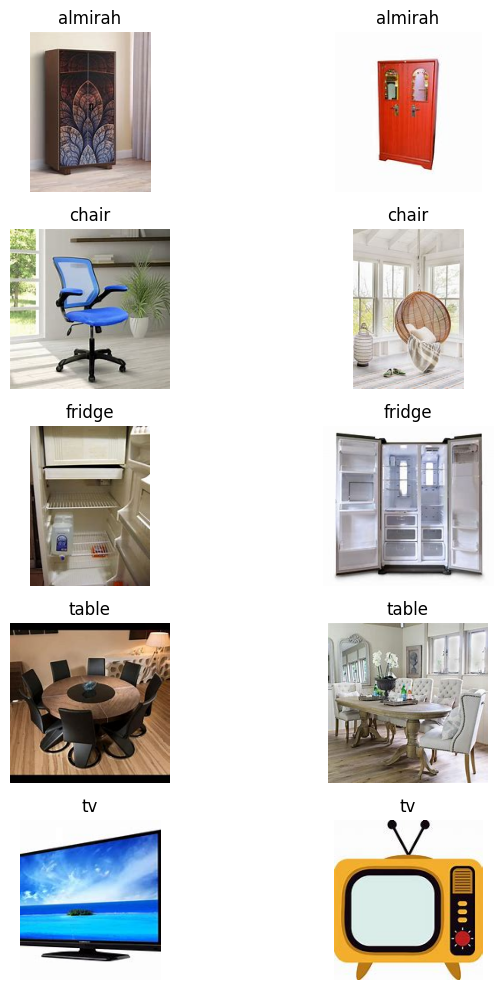

In [7]:
# Display sample images from each category
fig, axes = plt.subplots(len(CATEGORIES), 2, figsize=(8, 10))

for i, category in enumerate(CATEGORIES):
    category_path = os.path.join(DATA_PATH, category)
    if os.path.exists(category_path):
        image_files = [f for f in os.listdir(category_path) 
                      if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        
        sample_files = random.sample(image_files, 2)
        
        for j, img_file in enumerate(sample_files):
            img_path = os.path.join(category_path, img_file)
            try:
                img = Image.open(img_path)
                axes[i, j].imshow(img)
                axes[i, j].set_title(f"{folder_to_class[category]}")
                axes[i, j].axis('off')
            except Exception as e:
                axes[i, j].text(0.5, 0.5, 'Error loading image', 
                               ha='center', va='center', transform=axes[i, j].transAxes)
                axes[i, j].axis('off')

plt.tight_layout()
plt.show()

## 4. Data Loading and Preprocessing

In [8]:
# Define preprocessing parameters
IMG_SIZE = 224
BATCH_SIZE = 32
CHANNELS = 3

print(f"Image size: {IMG_SIZE}x{IMG_SIZE}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Channels: {CHANNELS}")

Image size: 224x224
Batch size: 32
Channels: 3


In [9]:
# Create file lists and labels
def create_file_lists(data_path, categories):
    file_paths = []
    labels = []
    
    print("Creating file lists...")
    
    for category in categories:
        category_path = os.path.join(data_path, category)
        class_name = folder_to_class[category]
        
        if os.path.exists(category_path):
            image_files = [f for f in os.listdir(category_path) 
                          if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
            
            print(f"Found {len(image_files)} images in {class_name}")
            
            for img_file in image_files:
                img_path = os.path.join(category_path, img_file)
                file_paths.append(img_path)
                labels.append(class_name)
    
    print(f"\nTotal files indexed: {len(file_paths)}")
    return file_paths, labels

file_paths, labels = create_file_lists(DATA_PATH, CATEGORIES)

# Create label encoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(labels)
y_categorical = to_categorical(y_encoded, num_classes=len(CLASS_NAMES))

print("File indexing complete!")
print(f"Total files: {len(file_paths)}")
print(f"Classes: {CLASS_NAMES}")

Creating file lists...
Found 3000 images in almirah
Found 3000 images in chair
Found 3000 images in fridge
Found 3000 images in table
Found 3000 images in tv

Total files indexed: 15000
File indexing complete!
Total files: 15000
Classes: ['almirah', 'chair', 'fridge', 'table', 'tv']


In [10]:
# Dataset summary
print("=== Dataset Summary ===")
print(f"Total files indexed: {len(file_paths)}")
print(f"Number of classes: {len(CLASS_NAMES)}")

class_counts = Counter(labels)
print(f"\nClass distribution:")
for class_name, count in class_counts.items():
    print(f"  {class_name}: {count} images")

# Sample image properties analysis
print(f"\nAnalyzing sample images...")
sample_indices = random.sample(range(len(file_paths)), min(50, len(file_paths)))
sample_widths, sample_heights = [], []

for idx in sample_indices:
    try:
        with Image.open(file_paths[idx]) as img:
            width, height = img.size
            sample_widths.append(width)
            sample_heights.append(height)
    except Exception as e:
        print(f"Error with {file_paths[idx]}: {e}")

print(f"Sample analysis from {len(sample_widths)} images:")
print(f"Width range: {min(sample_widths)} - {max(sample_widths)} (avg: {np.mean(sample_widths):.0f})")
print(f"Height range: {min(sample_heights)} - {max(sample_heights)} (avg: {np.mean(sample_heights):.0f})")
print(f"\nAnalysis complete!")

=== Dataset Summary ===
Total files indexed: 15000
Number of classes: 5

Class distribution:
  almirah: 3000 images
  chair: 3000 images
  fridge: 3000 images
  table: 3000 images
  tv: 3000 images

Analyzing sample images...
Sample analysis from 50 images:
Width range: 116 - 307 (avg: 195)
Height range: 169 - 220 (avg: 193)

Analysis complete!


## 5. Data Augmentation Setup

In [11]:
# Data Augmentation Setup
def create_augmentation():
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        zoom_range=0.2,
        fill_mode='nearest'
    )
    return datagen

augmentation = create_augmentation()
print("Data augmentation configured:")
print("- Rotation: ±20 degrees")
print("- Width/Height shift: ±20%")
print("- Horizontal flip: Yes")
print("- Zoom: ±20%")

Data augmentation configured:
- Rotation: ±20 degrees
- Width/Height shift: ±20%
- Horizontal flip: Yes
- Zoom: ±20%


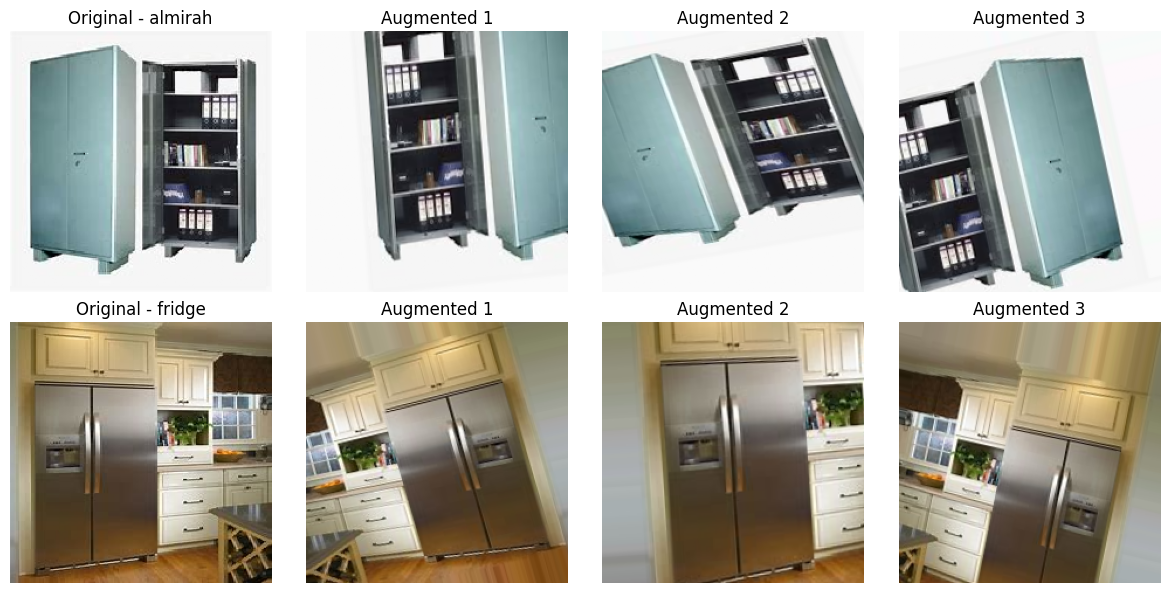

Augmentation examples shown


In [12]:
# Show augmentation examples
fig, axes = plt.subplots(2, 4, figsize=(12, 6))

sample_indices = random.sample(range(len(file_paths)), 2)

for i, idx in enumerate(sample_indices):
    img_path = file_paths[idx]
    label = labels[idx]
    
    try:
        img = load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
        img_array = img_to_array(img) / 255.0
        
        axes[i, 0].imshow(img_array)
        axes[i, 0].set_title(f'Original - {label}')
        axes[i, 0].axis('off')
        
        img_batch = img_array.reshape((1,) + img_array.shape)
        aug_iter = augmentation.flow(img_batch, batch_size=1)
        
        for j in range(1, 4):
            aug_img = next(aug_iter)[0]
            axes[i, j].imshow(aug_img)
            axes[i, j].set_title(f'Augmented {j}')
            axes[i, j].axis('off')
            
    except Exception as e:
        for j in range(4):
            axes[i, j].text(0.5, 0.5, f'Error: {str(e)[:20]}...', 
                           ha='center', va='center', transform=axes[i, j].transAxes)
            axes[i, j].axis('off')

plt.tight_layout()
plt.show()
print("Augmentation examples shown")

## 6. Train/Validation/Test Split Strategy

In [13]:
# Data splitting
from sklearn.model_selection import train_test_split

file_paths_array = np.array(file_paths)
labels_array = np.array(labels)

# Split: train vs test (80% vs 20%)
paths_train_val, paths_test, labels_train_val, labels_test = train_test_split(
    file_paths_array, labels_array, test_size=0.2, random_state=42, stratify=labels_array
)

# Split: train vs validation (80% vs 20% of remaining data)
paths_train, paths_val, labels_train, labels_val = train_test_split(
    paths_train_val, labels_train_val, test_size=0.25, random_state=42, stratify=labels_train_val
)

print("Data Split Complete:")
print(f"Training set:   {len(paths_train)} images ({len(paths_train)/len(file_paths)*100:.1f}%)")
print(f"Validation set: {len(paths_val)} images ({len(paths_val)/len(file_paths)*100:.1f}%)")
print(f"Test set:       {len(paths_test)} images ({len(paths_test)/len(file_paths)*100:.1f}%)")
print(f"Total:          {len(paths_train) + len(paths_val) + len(paths_test)} images")

# Encode labels for each split
y_train_encoded = label_encoder.transform(labels_train)
y_val_encoded = label_encoder.transform(labels_val)
y_test_encoded = label_encoder.transform(labels_test)

y_train = to_categorical(y_train_encoded, num_classes=len(CLASS_NAMES))
y_val = to_categorical(y_val_encoded, num_classes=len(CLASS_NAMES))
y_test = to_categorical(y_test_encoded, num_classes=len(CLASS_NAMES))

Data Split Complete:
Training set:   9000 images (60.0%)
Validation set: 3000 images (20.0%)
Test set:       3000 images (20.0%)
Total:          15000 images


In [14]:
# Verify balanced splits
def check_split_balance(y_data, split_name):
    class_indices = y_data.argmax(axis=1)
    class_counts = Counter(class_indices)
    
    print(f"\n{split_name} set distribution:")
    for i, class_name in enumerate(CLASS_NAMES):
        count = class_counts.get(i, 0)
        percentage = (count / len(y_data)) * 100
        print(f"  {class_name}: {count} images ({percentage:.1f}%)")

check_split_balance(y_train, "Training")
check_split_balance(y_val, "Validation") 
check_split_balance(y_test, "Test")


Training set distribution:
  almirah: 1800 images (20.0%)
  chair: 1800 images (20.0%)
  fridge: 1800 images (20.0%)
  table: 1800 images (20.0%)
  tv: 1800 images (20.0%)

Validation set distribution:
  almirah: 600 images (20.0%)
  chair: 600 images (20.0%)
  fridge: 600 images (20.0%)
  table: 600 images (20.0%)
  tv: 600 images (20.0%)

Test set distribution:
  almirah: 600 images (20.0%)
  chair: 600 images (20.0%)
  fridge: 600 images (20.0%)
  table: 600 images (20.0%)
  tv: 600 images (20.0%)


## 7. Data Preparation for CNN Training

In [15]:
# Create data generators for CNN training
def create_data_generator(file_paths, labels, batch_size=32, shuffle=True, augment=False):
    def data_generator():
        indices = np.arange(len(file_paths))
        while True:
            if shuffle:
                np.random.shuffle(indices)
            
            for start_idx in range(0, len(indices), batch_size):
                batch_indices = indices[start_idx:start_idx + batch_size]
                batch_paths = file_paths[batch_indices]
                batch_labels = labels[batch_indices]
                
                batch_images = []
                for path in batch_paths:
                    try:
                        img = load_img(path, target_size=(IMG_SIZE, IMG_SIZE))
                        img_array = img_to_array(img) / 255.0
                        batch_images.append(img_array)
                    except Exception as e:
                        print(f"Skipping corrupted image: {path}")
                        continue
                
                if len(batch_images) > 0:
                    batch_images = np.array(batch_images)
                    actual_batch_size = len(batch_images)
                    batch_labels = batch_labels[:actual_batch_size]
                    
                    if augment:
                        for i in range(len(batch_images)):
                            if np.random.random() > 0.5:
                                img_batch = batch_images[i:i+1]
                                aug_iter = augmentation.flow(img_batch, batch_size=1)
                                batch_images[i] = next(aug_iter)[0]
                    
                    yield batch_images, batch_labels
    
    return data_generator

# Create generators
train_generator = create_data_generator(paths_train, y_train, BATCH_SIZE, shuffle=True, augment=True)
val_generator = create_data_generator(paths_val, y_val, BATCH_SIZE, shuffle=False, augment=False)
test_generator = create_data_generator(paths_test, y_test, BATCH_SIZE, shuffle=False, augment=False)

# Calculate steps per epoch
steps_per_epoch = len(paths_train) // BATCH_SIZE
validation_steps = len(paths_val) // BATCH_SIZE
test_steps = len(paths_test) // BATCH_SIZE

print("Data generators created!")
print(f"Training steps per epoch: {steps_per_epoch}")
print(f"Validation steps: {validation_steps}")
print(f"Test steps: {test_steps}")
print(f"Batch size: {BATCH_SIZE}")

Data generators created!
Training steps per epoch: 281
Validation steps: 93
Test steps: 93
Batch size: 32


## 8. Save Processed Data

In [17]:
# Save processed data for CNN training
import pickle

if IN_COLAB:
    processed_dir = '/content/processed_data'
else:
    processed_dir = PATHS['processed_data']

os.makedirs(processed_dir, exist_ok=True)

# Save file paths and labels
np.save(os.path.join(processed_dir, 'paths_train.npy'), paths_train)
np.save(os.path.join(processed_dir, 'paths_val.npy'), paths_val)
np.save(os.path.join(processed_dir, 'paths_test.npy'), paths_test)
np.save(os.path.join(processed_dir, 'y_train.npy'), y_train)
np.save(os.path.join(processed_dir, 'y_val.npy'), y_val)
np.save(os.path.join(processed_dir, 'y_test.npy'), y_test)

# Save label encoder
with open(os.path.join(processed_dir, 'label_encoder.pkl'), 'wb') as f:
    pickle.dump(label_encoder, f)

# Save configuration
config = {
    'img_size': IMG_SIZE,
    'batch_size': BATCH_SIZE,
    'classes': CLASS_NAMES,
    'num_classes': len(CLASS_NAMES),
    'steps_per_epoch': steps_per_epoch,
    'validation_steps': validation_steps,
    'test_steps': test_steps,
    'total_train_samples': len(paths_train),
    'total_val_samples': len(paths_val),
    'total_test_samples': len(paths_test),
    'environment': 'Google Colab' if IN_COLAB else 'Local Machine',
    'data_path': DATA_PATH
}

with open(os.path.join(processed_dir, 'config.pkl'), 'wb') as f:
    pickle.dump(config, f)

# Test generator
print("Testing data generator...")
train_gen = train_generator()
batch_x, batch_y = next(train_gen)
print(f"Generator working! Batch shape: {batch_x.shape}, Labels shape: {batch_y.shape}")

print(f"\nData setup saved successfully!")
print(f"Files saved in {processed_dir}/:")
print("- paths_train.npy, paths_val.npy, paths_test.npy")
print("- y_train.npy, y_val.npy, y_test.npy")
print("- label_encoder.pkl")
print("- config.pkl")
print(f"\nReady for CNN training!")

Testing data generator...
Generator working! Batch shape: (32, 224, 224, 3), Labels shape: (32, 5)

Data setup saved successfully!
Files saved in /home/pimanzi/furniture_classification/processed_data/:
- paths_train.npy, paths_val.npy, paths_test.npy
- y_train.npy, y_val.npy, y_test.npy
- label_encoder.pkl
- config.pkl

Ready for CNN training!
Generator working! Batch shape: (32, 224, 224, 3), Labels shape: (32, 5)

Data setup saved successfully!
Files saved in /home/pimanzi/furniture_classification/processed_data/:
- paths_train.npy, paths_val.npy, paths_test.npy
- y_train.npy, y_val.npy, y_test.npy
- label_encoder.pkl
- config.pkl

Ready for CNN training!


## 9. Summary

In [18]:
# Data Processing Summary
print("=" * 60)
print("    FURNITURE CLASSIFICATION - DATA PROCESSING")
print("=" * 60)

print(f"Dataset: {len(file_paths)} total images")
print(f"Classes: {', '.join(CLASS_NAMES)}")
print(f"Image size: {IMG_SIZE}x{IMG_SIZE}x3")
print(f"Training: {len(paths_train)} images")
print(f"Validation: {len(paths_val)} images") 
print(f"Test: {len(paths_test)} images")
print(f"Batch size: {BATCH_SIZE}")
print(f"Augmentation: Applied during training")
print(f"Steps per epoch: {steps_per_epoch}")

print(f"\nData processing completed!")
print("=" * 60)

    FURNITURE CLASSIFICATION - DATA PROCESSING
Dataset: 15000 total images
Classes: almirah, chair, fridge, table, tv
Image size: 224x224x3
Training: 9000 images
Validation: 3000 images
Test: 3000 images
Batch size: 32
Augmentation: Applied during training
Steps per epoch: 281

Data processing completed!
